In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
%matplotlib inline
df = pd.read_csv('properties.csv')
print(df.shape)
print(df.isnull().sum())
df.drop(columns='Unnamed: 0', inplace=True)
df.rename(columns={'Price ($)':"Price"}, inplace=True)
print(df.head())

(25347, 6)
Unnamed: 0      0
Address         0
AreaName      483
Price ($)       0
lat             0
lng             0
dtype: int64
                            Address           AreaName   Price        lat   
0       86 Waterford Dr Toronto, ON           Richview  999888  43.679882  \
1  #80 - 100 BEDDOE DR Hamilton, ON     Chedoke Park B  399900  43.250000   
2    213 Bowman Street Hamilton, ON  Ainslie Wood East  479000  43.251690   
3      102 NEIL Avenue Hamilton, ON          Greenford  285900  43.227161   
4   #1409 - 230 King St Toronto, ON           Downtown  362000  43.651478   

         lng  
0 -79.544266  
1 -79.904396  
2 -79.919357  
3 -79.767403  
4 -79.368118  


### Remove outliers:

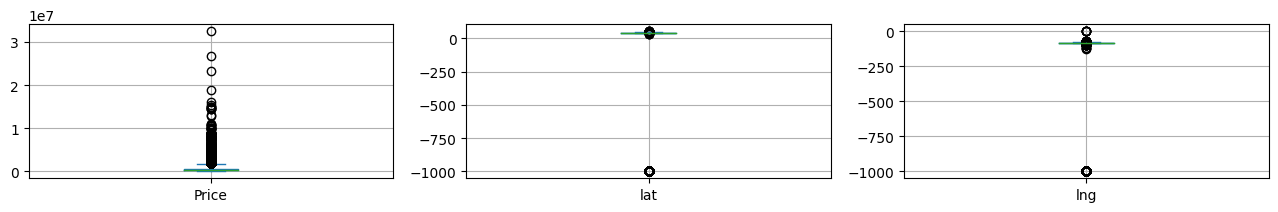

In [18]:
fig,axes = plt.subplots(1,3,figsize=(16,2))
df['Price'].plot.box(whis=3, grid=True, ax = axes[0])
df['lat'].plot.box(whis=3, grid=True, ax = axes[1])
df['lng'].plot.box(whis=3, grid=True, ax = axes[2])
plt.show()

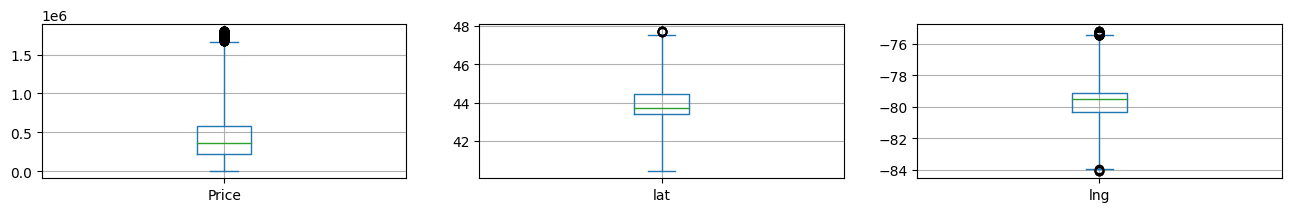

Index(['Address', 'AreaName', 'Price', 'lat', 'lng'], dtype='object') (23789, 5)


In [19]:
def remove_outliers(data, *cols):
    for col in cols:
        q1 = data[col].quantile(q = 0.25)
        q3 = data[col].quantile(q = 0.75) 
        iqr = q3 - q1
        t1 = q1 - 3 * iqr
        t2 = q3 + 3 * iqr
        data = data[(data[col] > t1) & (data[col] < t2)]
    return data

data_c = remove_outliers(df, 'Price','lng', 'lat')
data_c.shape
fig,axes = plt.subplots(1,3,figsize=(16,2))
data_c['Price'].plot.box(whis=3, grid=True, ax = axes[0])
data_c['lat'].plot.box(whis=3, grid=True, ax = axes[1])
data_c['lng'].plot.box(whis=3, grid=True, ax = axes[2])
plt.show()
print(data_c.columns,data_c.shape)

### Use Random Forest to fill the null AreaName, classify the area of property based on lng and lat information:

In [20]:
# Seperate data with/without null:
data_withna = data_c.loc[data_c['AreaName'].isna()]
data_wona = data_c.loc[data_c['AreaName'].notna()]
print(data_withna.shape, data_wona.shape)

(296, 5) (23493, 5)


In [21]:
# Split train/test dataset:
from sklearn.model_selection import train_test_split
training, testing = train_test_split(data_wona,test_size=0.25, random_state=1)

x_train = training.copy()[['lat','lng']]
y_train = training.copy()['AreaName']

x_test = testing.copy()[['lat','lng']]
y_test = testing.copy()['AreaName']

print(training.shape)
print(testing.shape)

(17619, 5)
(5874, 5)


In [22]:
# Build Random Forest Classifier workflow:
from sklearn.preprocessing import PowerTransformer, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier 
rf_model = RandomForestClassifier(criterion='gini',
                                  n_jobs=16,
                                  max_features = 'auto',
                                  n_estimators = 100,
                                  max_depth = None,
                                  random_state=133)
pipe_clf = Pipeline([
        ('sc',StandardScaler()),
        ('power_trans',PowerTransformer()),
        ('polynom_trans',PolynomialFeatures(degree=2)),
        ('rf_clf', rf_model)
        ])
print(pipe_clf)

Pipeline(steps=[('sc', StandardScaler()), ('power_trans', PowerTransformer()),
                ('polynom_trans', PolynomialFeatures()),
                ('rf_clf',
                 RandomForestClassifier(max_features='auto', n_jobs=16,
                                        random_state=133))])


In [23]:
# Fit model & Check the accuracy score of the random forest model:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
pipe_clf.fit(x_train,y_train)
y_predict = pipe_clf.predict(x_test)
print(f'accuracy score is: {accuracy_score(y_test,y_predict)}')

accuracy score is: 0.9159005788219271


*This model seems pretty reliable. :)*

### Apply the model to fill any missing AreaName:

In [24]:
import warnings
warnings.filterwarnings('ignore') 
data_withna['AreaName'] = pipe_clf.predict(data_withna[['lat','lng']])
data_withna.head()

,Address,AreaName,Price,lat,lng
209,"7393 Wellington Rd 51 . Ariss, ON",Guelph,699000,43.596718,-80.340660
1186,"152 MARR Drive Elora, ON",Elora,399900,43.693314,-80.437492
2773,"17 Dan Sheehan Lane Clarington, ON",Bowmanville,550000,43.931091,-78.707405
2874,328 Wicklow Beach Rd Alnwick Haldimand Townshi...,Cobourg,629000,43.976543,-77.962921
2936,"WALKER LAKE DR WALKER LAKE DR Lake Of Bays, ON",Huntsville,69900,45.378361,-79.092339


In [25]:
# Combine two forms & export
data_f = pd.concat([data_wona, data_withna])
data_f.head()
# data_f.to_csv('properties_output.csv')

,Address,AreaName,Price,lat,lng
0,"86 Waterford Dr Toronto, ON",Richview,999888,43.679882,-79.544266
1,"#80 - 100 BEDDOE DR Hamilton, ON",Chedoke Park B,399900,43.250000,-79.904396
2,"213 Bowman Street Hamilton, ON",Ainslie Wood East,479000,43.251690,-79.919357
3,"102 NEIL Avenue Hamilton, ON",Greenford,285900,43.227161,-79.767403
4,"#1409 - 230 King St Toronto, ON",Downtown,362000,43.651478,-79.368118


In [42]:
# Remove rows with missing values in latitude or longitude
data_f = data_f.dropna(subset=['lat', 'lng'])

# Calculate the mean latitude and longitude
mean_lat = data_f['lat'].mean()
mean_lng = data_f['lng'].mean()

# Create a folium map centered at the mean latitude and longitude
m = folium.Map(location=[mean_lat, mean_lng], zoom_start=12)

# Add a heatmap layer to the map
from folium.plugins import HeatMap
heat_data = [[row['lat'],row['lng']] for index, row in data_f.iterrows()]
HeatMap(heat_data, radius=15).add_to(m)

# Display the map
m
